In [71]:
# Leave-One-User-Out-Cross-Validation with Radom Forest Classifier
# Author: Anastassiya Makarenko, Universität Freiburg, 2017.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

# Number of classes.
n_classes = 5

# Read data.
data = pd.read_csv('data.csv', header = 0, \
                   sep=',', index_col='id')
y_train_all = pd.Series()
y_test_all = pd.Series()
x_train_all = pd.Series()
x_test_all = pd.Series()
x_train_all = pd.Series()
preds_all = []
y_score_all = [[0 for x in range(n_classes)] for y in range(1)]
y_score_all = np.delete(y_score_all, (0), axis=0)
# Iterating over test persons.
for i in range(1,16):
    # Leave the person number 15 out (beacuase of missing data). 
    if i == 15: i += 1
    # Split the data in training and test sets.
    train, test = data[data['TP_ID']!=i], data[data['TP_ID']==i] # i means the number of the test person.
    train = train.drop(train[train['Activity'] == 'undef'].index)
    # Take only selected features.
    selected_features = train.iloc[:,[16,25,38,39,41,87,88,91,178,216,250,271,274]] # Index isn't count. Count starts from 0.
    length =len(selected_features)
    features = selected_features.columns[:length]
    x_train = train[features]
    x_train_all = x_train_all.append(x_train)
    x_test = test[features]
    x_test_all = x_test_all.append(x_test)
    y = train['Activity']
    # Concatinate all y from training data.
    y_train_all = y_train_all.append(y)
    y_test = test['Activity_test']
    # Concatinate all y from test data.
    y_test_all = y_test_all.append(y_test)
    # Create a random forest classifier.
    clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=20, bootstrap=True, \
                                 criterion='entropy', max_features=None, oob_score=False,\
                                 min_samples_split=4)
    # Train the classifier.
    #clf.fit(x_train, y)
    y_score = clf.fit(x_train, y).predict_proba(x_test)
    y_score_all = np.concatenate((y_score_all, y_score))
    #score = clf.score(x_test, y_test)
    # Apply the trained classifier to the test data (which, classifier has never seen before)
    preds = clf.predict(x_test)
    preds_all = np.append(preds_all, preds)
    
    
x_train_all = x_train_all.drop(x_train_all.columns[0], axis=1)
x_test_all = x_test_all.drop(x_test_all.columns[0], axis=1)

# Creating confusion matrix.
pd.crosstab(y_test_all, preds_all, rownames=['Actual Activity'], \
            colnames=['Predicted Activity'])

C:\Users\mak\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (14,84,204,216,255,261) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\mak\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\api.py:77: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


Predicted Activity,essen,lesen,rauch,still,trink
Actual Activity,,,,,
essen,949,62,14,10,18
lesen,90,91,17,67,18
rauch,30,21,76,28,29
still,27,52,22,418,16
trink,23,28,32,31,29


In [74]:
# Print the most relevant features.
list(zip(x_train_all, clf.feature_importances_))

[('agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
  0.048573133877133953),
 ('agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"',
  0.29639919984853041),
 ('ar_coefficient__k_10__coeff_1', 0.082681547528791241),
 ('abs_energy', 0.045062315262854577),
 ('partial_autocorrelation__lag_3', 0.10574636870254379),
 ('augmented_dickey_fuller__attr_"pvalue"', 0.052097568796868679),
 ('augmented_dickey_fuller__attr_"teststat"', 0.071822723001080155),
 ('change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4',
  0.10033597388204545),
 ('agg_autocorrelation__f_agg_"mean"', 0.031436711017012633),
 ('partial_autocorrelation__lag_8', 0.035372635418539723),
 ('kurtosis', 0.038404059256670217),
 ('longest_strike_above_mean', 0.048189402544317972),
 ('fft_coefficient__coeff_73__attr_"abs"', 0.043878360863611111)]

In [75]:
# Print the average for different metrics.
print('F1 score = ', f1_score(y_test_all, preds_all, average="macro"))
print('Precision =', precision_score(y_test_all, preds_all, average="macro"))
print('Recall =', recall_score(y_test_all, preds_all, average="macro"))
print('Accuracy =', accuracy_score(y_test_all, preds_all))

F1 score =  0.53005488046
Precision = 0.539309009327
Recall = 0.523987686098
Accuracy = 0.71110100091


In [76]:
# Print the metrics for all classes and the weight average for all classes.
print(classification_report(y_test_all, preds_all, labels=['still', 'essen', 'trink', \
                                                   'lesen', 'rauch']))

             precision    recall  f1-score   support

      still       0.75      0.78      0.77       535
      essen       0.85      0.90      0.87      1053
      trink       0.26      0.20      0.23       143
      lesen       0.36      0.32      0.34       283
      rauch       0.47      0.41      0.44       184

avg / total       0.69      0.71      0.70      2198



In [77]:
# Reshape data.
y_test_all_ar = [[0 for x in range(n_classes)] for y in range(1)] 
for i in y_test_all:
    if i == 'essen': y_test_all_ar = np.vstack((y_test_all_ar, [1, 0, 0, 0, 0]))
    if i == 'lesen': y_test_all_ar = np.vstack((y_test_all_ar, [0, 1, 0, 0, 0]))
    if i == 'rauch': y_test_all_ar = np.vstack((y_test_all_ar, [0, 0, 1, 0, 0]))
    if i == 'still': y_test_all_ar = np.vstack((y_test_all_ar, [0, 0, 0, 1, 0]))
    if i == 'trink': y_test_all_ar = np.vstack((y_test_all_ar, [0, 0, 0, 0, 1]))
y_test_all_ar = np.delete(y_test_all_ar, (0), axis=0)

(2198, 5)
(2198, 5)


In [78]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_all_ar[:, i], y_score_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_all_ar.ravel(), y_score_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

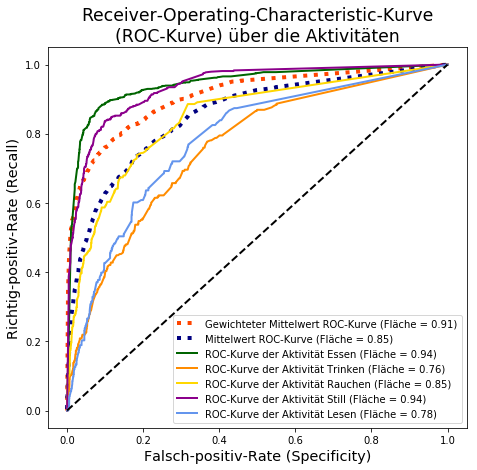

In [104]:
# Compute macro-average ROC curve and ROC area

lw = 2 # Line width.

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
figure = plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='Gewichteter Mittelwert ROC-Kurve (Fläche = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='orangered', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Mittelwert ROC-Kurve (Fläche = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['darkgreen', 'darkorange', 'gold','darkmagenta', 'cornflowerblue'])
#colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green', 'red'])
names = ['Essen', 'Trinken','Rauchen', 'Still', 'Lesen']
#names = ['Essen', 'Still','Trinken', 'Lesen', 'Rauchen']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC-Kurve der Aktivität {0} (Fläche = {1:0.2f})'
             ''.format(names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Falsch-positiv-Rate (Specificity)')
plt.ylabel('Richtig-positiv-Rate (Recall)')
plt.title('Receiver-Operating-Characteristic-Kurve\n(ROC-Kurve) über die Aktivitäten')
plt.legend(loc="lower right")

params = {'legend.fontsize': 'medium',
         'figure.figsize': (7.5, 7),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

plt.show()
figure.savefig('ROC-Kurve.png')